```c
#pragma omp parallel
    {
      for (size_t rep=0; rep<args.repetitions; rep++) {
#pragma omp for
        for (size_t i=0; i<args.array_len; i++)
          y[i] += 3.14 * x[i];
      }
    }
```

```c
    for (size_t rep=0; rep<args.repetitions; rep++) {
#pragma omp parallel for
      for (size_t i=0; i<args.array_len; i++)
        y[i] += 3.14 * x[i];
    }
```

In [17]:
! make CFLAGS='-O3 -march=native -fopenmp -Wall' -B omp-test

cc -O3 -march=native -fopenmp -Wall    omp-test.c   -o omp-test


In [18]:
! ./omp-test -r 10000

omp for         : 0.770512 ticks per entry
omp parallel for: 1.576261 ticks per entry
omp for         : 0.419312 ticks per entry
omp parallel for: 1.475976 ticks per entry
omp for         : 0.426896 ticks per entry
omp parallel for: 1.021856 ticks per entry
omp for         : 0.494572 ticks per entry
omp parallel for: 1.270378 ticks per entry
omp for         : 0.444213 ticks per entry
omp parallel for: 1.009316 ticks per entry
omp for         : 0.579121 ticks per entry
omp parallel for: 1.024148 ticks per entry
omp for         : 0.531494 ticks per entry
omp parallel for: 1.174585 ticks per entry
omp for         : 0.442223 ticks per entry
omp parallel for: 1.147614 ticks per entry
omp for         : 0.446249 ticks per entry
omp parallel for: 1.084162 ticks per entry
omp for         : 0.576802 ticks per entry
omp parallel for: 1.325817 ticks per entry


## Matrix-matrix multiply

### Start local

![BLIS GEMM kernels](blis-gemm-kernels.png)

![BLIS cache levels](blis-cache.png)

#### Further reading
* http://www.cs.utexas.edu/users/flame/pubs/blis2_toms_rev3.pdf
* http://www.cs.utexas.edu/users/flame/pubs/blis3_ipdps14.pdf

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Orthogonalization and QR factorization

Given a collection of vectors (columns of a matrix), we can find an orthogonal basis by applying the above procedure one column at a time and saving the result.  Let's think of the first two columns,
$$ \Bigg[ a_0 \, \Bigg| \, a_1 \Bigg] = \Bigg[ q_0 \,\Bigg|\, q_1 \Bigg]
\begin{bmatrix} r_{00} & r_{01} \\ 0 & r_{11} \end{bmatrix} . $$
#### Column 0
The equation for column 0 reads
$$ a_0 = q_0 r_{00} $$
and we require that $\lVert q_0 \rVert = 1$, thus
$$ r_{00} = \lVert a_0 \rVert $$
and
$$ q_0 = a_0 / r_{00} . $$
#### Column 1
This equation reads
$$ a_1 = q_0 r_{01} + q_1 r_{11} $$
where $a_1$ and $q_0$ are known and we will require that $q_0^T q_1 = 0$.
We can find the part of $a_1$ that is orthogonal to $q_0$ via
$$ (I - q_0 q_0^T) a_1 = a_1 - q_0 \underbrace{q_0^T a_1}_{r_{01}} $$
leaving a sub-problem equivalent to that of column 0.

[[ 1.00000000e+00  2.06727448e-17 -7.22457952e-17 -2.05232865e-16]
 [ 2.06727448e-17  1.00000000e+00  1.13635722e-16 -5.08904737e-16]
 [-7.22457952e-17  1.13635722e-16  1.00000000e+00  4.66276733e-17]
 [-2.05232865e-16 -5.08904737e-16  4.66276733e-17  1.00000000e+00]]
4.744563050812836e-16


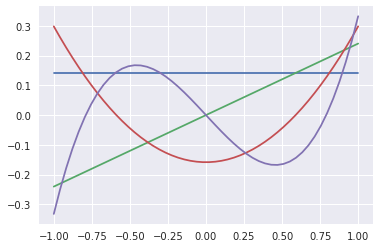

In [19]:
def gram_schmidt_naive(A):
    """Compute a QR factorization of A using the Gram-Schmidt algorithm"""
    Q = np.zeros_like(A)
    R = np.zeros((A.shape[1], A.shape[1]))
    for i in range(len(Q.T)):
        v = A[:,i].copy()
        for j in range(i):
            r = Q[:,j] @ v
            R[j,i] = r
            v -= Q[:,j] * r # "modified Gram-Schmidt"
        R[i,i] = np.linalg.norm(v)
        Q[:,i] = v / R[i,i]
    return Q, R

x = np.linspace(-1, 1)
A = np.vander(x, 4, increasing=True)
Q, R = gram_schmidt_naive(A)
print(Q.T @ Q)
print(np.linalg.norm(Q @ R - A))
plt.plot(x, Q);

### Theorem: all full-rank $m\times n$ matrices ($m \ge n$) have a unique $Q R$ factorization with $R_{j,j} > 0$.


In [20]:
m = 20
V = np.vander(np.linspace(-1,1,m), increasing=True)
Q, R = gram_schmidt_naive(V)

def qr_test(qr, V):
    Q, R = qr(V)
    m = len(Q.T)
    print('{:20} {:.2e} {:.2e}'.format(
        qr.__name__,
        np.linalg.norm(Q @ R - V),
        np.linalg.norm(Q.T @ Q - np.eye(m))))
    
qr_test(gram_schmidt_naive, V)
qr_test(np.linalg.qr, V)

gram_schmidt_naive   9.52e-16 3.04e-09
qr                   2.74e-15 2.39e-15


## Left-looking algorithms: reducing the number of inner products

In [6]:
def gram_schmidt_classical(A):
    Q = np.zeros_like(A)
    R = np.zeros((len(A.T),len(A.T)))
    for i in range(len(Q.T)):
        v = A[:,i].copy()
        R[:i,i] = Q[:,:i].T @ v
        v -= Q[:,:i] @ R[:i,i]
        R[i,i] = np.linalg.norm(v)
        Q[:,i] = v / R[i,i]
    return Q, R

qr_test(gram_schmidt_classical, V)

gram_schmidt_classical 9.14e-16 1.42e+00


Classical Gram-Schmidt is highly parallel, but unstable, as evidenced by the lack of orthogonality in $Q$.

### Right-looking algorithms

The implementations above have been "left-looking"; when working on column $i$, we compare it only to columns to the left (i.e., $j < i$).  We can reorder the algorithm to look to the right by projecting $q_i$ out of all columns $j > i$.  This algorithm is stable while being just as parallel as `gram_schmidt_classical`.

In [7]:
def gram_schmidt_modified(A):
    Q = A.copy()
    R = np.zeros((len(A.T), len(A.T)))
    for i in range(len(Q.T)):
        R[i,i] = np.linalg.norm(Q[:,i])
        Q[:,i] /= R[i,i]
        R[i,i+1:] = Q[:,i].T @ Q[:,i+1:]
        Q[:,i+1:] -= np.outer(Q[:,i], R[i,i+1:])
    return Q, R

qr_test(gram_schmidt_modified, V)

gram_schmidt_modified 8.32e-16 1.32e-08


## One reduction: Cholesky QR

In [9]:
def chol_qr(A):
    import scipy.linalg as la
    B = A.T @ A
    R = la.cholesky(B)
    Q = A @ la.inv(R)
    return Q, R
    
qr_test(chol_qr, V)

chol_qr              8.12e-15 1.07e-01


In [11]:
def chol_qr2(A):
    import scipy.linalg as la
    B = A.T @ A
    R = la.cholesky(B)
    Q = A @ la.inv(R)
    R2 = la.cholesky(Q.T @ Q)
    Q = Q @ la.inv(R2)
    R = R2 @ R
    return Q, R

qr_test(chol_qr2, V)

chol_qr2             8.36e-15 1.29e-15
